In [1]:
#Library Import 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns



C:\Users\roy.fong\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 2. Data Modeling (LinearRegression, RandomForest)
### Prepared by: FONG, Chun Wai
#### 2.1 Major Road Data

In [3]:
#Load File
df = pd.read_excel('laei-2019-major-roads-vkm-flows-speeds.xlsx')

In [4]:
print(df.shape)

#Remove hyphen
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df.replace('-', np.nan, inplace=True)

#Missing value Handling
df = df.dropna()

#Rename columns
df.columns = [x.strip() for x in df.columns]
df = df.rename(columns ={'Speed (km/hr) - Except Buses':'Speed'})

#Drop total columns
df = df.drop(['AADT 2019 - Total','VKM 2019 - Total'],axis=1)

print(df.shape)

C:\Users\roy.fong\AppData\Local\Temp\ipykernel_21896\3709496324.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
C:\Users\roy.fong\AppData\Local\Temp\ipykernel_21896\3709496324.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True)


In [5]:
#Handling AADT and VKM data
id_col = ['TOID','LAEI Zone', 'Borough', 'Road Classification','Speed','Link Length (m)']
aadt_col = [col for col in df.columns if col.startswith('AADT')]
vkm_col = [col for col in df.columns if col.startswith('VKM')]

In [6]:
#For AADT data
df_aadt = df[id_col + aadt_col]
df_aadt['Car'] = df_aadt['AADT Petrol Car'] + df_aadt['AADT Diesel Car'] + df_aadt['AADT Taxi']
df_aadt['Public Transport'] = df_aadt['AADT 2019 - Buses'] + df_aadt['AADT 2019 - Coaches']
df_aadt['PHV'] = df_aadt['AADT Petrol PHV'] + df_aadt['AADT Diesel PHV']
df_aadt['LGV'] = df_aadt['AADT Petrol LGV'] + df_aadt['AADT Diesel LGV']
df_aadt['Rigid'] = df_aadt['AADT 2019 - HGVs - Rigid - 2 Axles'] + df_aadt['AADT 2019 - HGVs - Rigid - 3 Axles'] + df_aadt['AADT 2019 - HGVs - Rigid - 4 or more Axles']
df_aadt['Artic'] = df_aadt['AADT 2019 - HGVs - Articulated - 3 to 4 Axles'] + df_aadt['AADT 2019 - HGVs - Articulated - 5 Axles'] + df_aadt['AADT 2019 - HGVs - Articulated - 6 Axles']
aadt_col = ['Car','Public Transport','PHV','LGV','Rigid','Artic']
df_aadt = df_aadt.melt(id_vars=id_col,
                  value_vars=aadt_col, var_name='VehicleType', value_name='AADT')

df_aadt['VehicleType'] = df_aadt['VehicleType'].str.replace('AADT 2019 - ','')
df_aadt['VehicleType'] = df_aadt['VehicleType'].str.replace('AADT ','')
df_aadt

C:\Users\roy.fong\AppData\Local\Temp\ipykernel_21896\2768449500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aadt['Car'] = df_aadt['AADT Petrol Car'] + df_aadt['AADT Diesel Car'] + df_aadt['AADT Taxi']
C:\Users\roy.fong\AppData\Local\Temp\ipykernel_21896\2768449500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aadt['Public Transport'] = df_aadt['AADT 2019 - Buses'] + df_aadt['AADT 2019 - Coaches']
C:\Users\roy.fong\AppData\Local\Temp\ipykernel_21896\2768449500.py:5: SettingWithCopyWarning

,TOID,LAEI Zone,Borough,Road Classification,Speed,Link Length (m),VehicleType,AADT
0,osgb4000000030400377,Non-GLA,Non-GLA,A Road,44.0,22,Car,5898.0
1,osgb4000000030151183,Non-GLA,Non-GLA,A Road,37.0,105,Car,6228.0
2,osgb4000000030090345,Non-GLA,Non-GLA,A Road,46.0,187,Car,3828.0
3,osgb4000000027948232,Non-GLA,Non-GLA,A Road,34.0,51,Car,7465.0
4,osgb4000000030078494,Non-GLA,Non-GLA,A Road,42.0,511,Car,13680.0
...,...,...,...,...,...,...,...,...
268951,osgb4000000031088429,Central London,Westminster,B Road,20.0,21,Artic,9.0
268952,osgb4000000031088430,Central London,Westminster,B Road,20.0,21,Artic,6.0
268953,osgb4000000030419424,Central London,Islington,B Road,25.0,16,Artic,3.0
268954,osgb4000000030419425,Central London,Islington,B Road,26.0,25,Artic,3.0


In [7]:
#For VKM data
df_vkm = df[id_col + vkm_col]
df_vkm['Car'] = df_vkm['VKM Petrol Car'] + df_vkm['VKM Diesel Car'] + df_vkm['VKM Taxi']
df_vkm['Public Transport'] = df_vkm['VKM 2019 - Buses'] + df_vkm['VKM 2019 - Coaches']
df_vkm['PHV'] = df_vkm['VKM Petrol PHV'] + df_vkm['VKM Diesel PHV']
df_vkm['LGV'] = df_vkm['VKM Petrol LGV'] + df_vkm['VKM Diesel LGV']
df_vkm['Rigid'] = df_vkm['VKM 2019 - HGVs - Rigid - 2 Axles'] + df_vkm['VKM 2019 - HGVs - Rigid - 3 Axles'] + df_vkm['VKM 2019 - HGVs - Rigid - 4 or more Axles']
df_vkm['Artic'] = df_vkm['VKM 2019 - HGVs - Articulated - 3 to 4 Axles'] + df_vkm['VKM 2019 - HGVs - Articulated - 5 Axles'] + df_vkm['VKM 2019 - HGVs - Articulated - 6 Axles']
vkm_col = ['Car','Public Transport','PHV','LGV','Rigid','Artic']
df_vkm = df_vkm.melt(id_vars=id_col,
                  value_vars=vkm_col, var_name='VehicleType', value_name='VKM')


C:\Users\roy.fong\AppData\Local\Temp\ipykernel_21896\374338955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vkm['Car'] = df_vkm['VKM Petrol Car'] + df_vkm['VKM Diesel Car'] + df_vkm['VKM Taxi']
C:\Users\roy.fong\AppData\Local\Temp\ipykernel_21896\374338955.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vkm['Public Transport'] = df_vkm['VKM 2019 - Buses'] + df_vkm['VKM 2019 - Coaches']
C:\Users\roy.fong\AppData\Local\Temp\ipykernel_21896\374338955.py:5: SettingWithCopyWarning: 
A value is t

In [8]:
#Merge AADT and VKM data
df_clean = pd.merge(df_aadt, df_vkm, on=id_col + ['VehicleType'], how='inner')

In [9]:
#Check VehicleType
df_clean.VehicleType.unique()

array(['Car', 'Public Transport', 'PHV', 'LGV', 'Rigid', 'Artic'],
      dtype=object)

### 2.2 Emission Data

In [11]:
#Load Data - Choose Co2 sheet
emission = pd.read_excel('LAEI2019-nox-pm-co2-major-roads-link-emissions.xlsx',sheet_name='CO2 Road Link Emissions')

In [12]:
#Missing value Handling
print(emission.shape)
emission = emission.dropna()
print(emission.shape)

(79439, 51)
(79372, 51)


In [13]:
#Handling emission data
TargetYear_col = [col for col in emission.columns if col.endswith('2019') or col in ['TOID', 'pollutant', 'emissions-units']]
emission = emission[TargetYear_col]
emission['Car'] = emission['Road-Car-Petrol-2019'] + emission['Road-Car-Diesel-2019'] + emission['Road-Taxi-2019']
emission['Public Transport'] = emission['Road-TfL-Bus-2019'] + emission['Road-Non-TfL-Bus-or-Coach-2019']
emission['PHV'] = emission['Road-PHV-Petrol-2019'] + emission['Road-PHV-Diesel-2019']
emission['LGV'] = emission['Road-LGV-Petrol-2019'] + emission['Road-LGV-Diesel-2019']
emission['Rigid'] = emission['Road-HGV-Rigid-2019']
emission['Artic'] = emission['Road-HGV-Articulated-2019']
emission_col = ['Car','Public Transport','PHV','LGV','Rigid','Artic']
emission = emission[['TOID']+emission_col]


In [14]:
#Melt table for VehicleType
emission_clean = emission.melt(id_vars=['TOID'],
                       value_vars=emission_col, var_name='VehicleType', value_name='Emission Value')

In [15]:
emission_clean.head()

,TOID,VehicleType,Emission Value
0,osgb4000000027865913,Car,4475.104067
1,osgb4000000027865914,Car,4408.603867
2,osgb4000000027865915,Car,5005.822564
3,osgb4000000027865916,Car,5680.263177
4,osgb4000000027865917,Car,3392.920660


### 2.3 Main DataFrame

In [16]:
#Merge table for main dataframe
main_df = pd.merge(df_clean,emission_clean,on=['TOID','VehicleType'],how='inner')
main_df.shape

(268818, 10)

In [17]:
main_df.head()

,TOID,LAEI Zone,Borough,Road Classification,Speed,Link Length (m),VehicleType,AADT,VKM,Emission Value
0,osgb4000000030400377,Non-GLA,Non-GLA,A Road,44.0,22,Car,5898.0,47357.0,6.356939
1,osgb4000000030151183,Non-GLA,Non-GLA,A Road,37.0,105,Car,6228.0,238209.0,34.176009
2,osgb4000000030090345,Non-GLA,Non-GLA,A Road,46.0,187,Car,3828.0,261606.0,34.818740
3,osgb4000000027948232,Non-GLA,Non-GLA,A Road,34.0,51,Car,7465.0,138959.0,20.812516
4,osgb4000000030078494,Non-GLA,Non-GLA,A Road,42.0,511,Car,13680.0,2551410.0,348.135065


### 2.4 LinearRegression

In [64]:
#Define function for modelling
X = main_df.iloc[:, 4:-1]
y = main_df.iloc[:, -1:]
def lr_model(X, y, model_name='lr',alpha=0.1,cross_val=False,scoring='r2'):

    # build the model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if model_name=='l1':
        lm = Lasso(alpha=alpha)
    elif model_name=='l2':
        lm = Ridge(alpha=alpha)
    elif model_name=='rf':
        lm = RandomForestRegressor(n_estimators=100, random_state=42)
    else:
        lm = LinearRegression(fit_intercept=True)
    encoder_one_hot = OneHotEncoder()
    X_train_e = encoder_one_hot.fit_transform(X_train['VehicleType'].values.reshape(-1, 1))
    X_test_e = encoder_one_hot.transform(X_test['VehicleType'].values.reshape(-1, 1))

    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train.drop('VehicleType',axis=1))
    X_test_num = scaler.transform(X_test.drop('VehicleType',axis=1))

    X_train = np.hstack((X_train_e.toarray(), X_train_num))
    X_test = np.hstack((X_test_e.toarray(), X_test_num))

    if cross_val==True:
        scores = cross_val_score(lm, X_train, y_train, cv=5, scoring=scoring)
        return {scoring:scores, f'Average of {scoring}':scores.mean()}

    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    if model_name != 'rf':
        print("")
        # Coefficient
        print('Coefficients:')
        print(lm.coef_)

        print("")
        # Intercept
        print('Intercept:')
        print(lm.intercept_)

        y_test = y_test.values.ravel()  # or use .flatten() to achieve the same
        y_pred = y_pred.ravel()         # or use .flatten()

        # 1. Regression Line Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, color="blue", label='Data Points')
        # Add the best fit line (regression line)
        m, b = np.polyfit(y_test, y_pred, 1)
        plt.plot(y_test, m * y_test + b, color="red", label="Best Fit Line", linewidth=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Regression Line Plot')
        plt.legend()
        plt.show()

        # 2. Explained Variance (Bar Plot)
        r2 = r2_score(y_test, y_pred)
        explained_variance = r2
        unexplained_variance = 1 - r2

        plt.figure(figsize=(6, 6))
        plt.bar(['Explained Variance', 'Unexplained Variance'], [explained_variance, unexplained_variance], color=['green', 'red'])
        plt.title('Explained vs Unexplained Variance (R^2)')
        plt.ylabel('Variance Proportion')
        plt.show()
    
    return {'MAE': mae, 'MSE': mse, 'R^2': r2 }


Coefficients:
[[ 9.65879952e+10  9.65879952e+10  9.65879952e+10  9.65879952e+10
   9.65879952e+10  9.65879952e+10 -2.52347320e+00  7.76636766e+00
   4.68475547e+00  3.43638846e+01]]

Intercept:
[-9.65879952e+10]


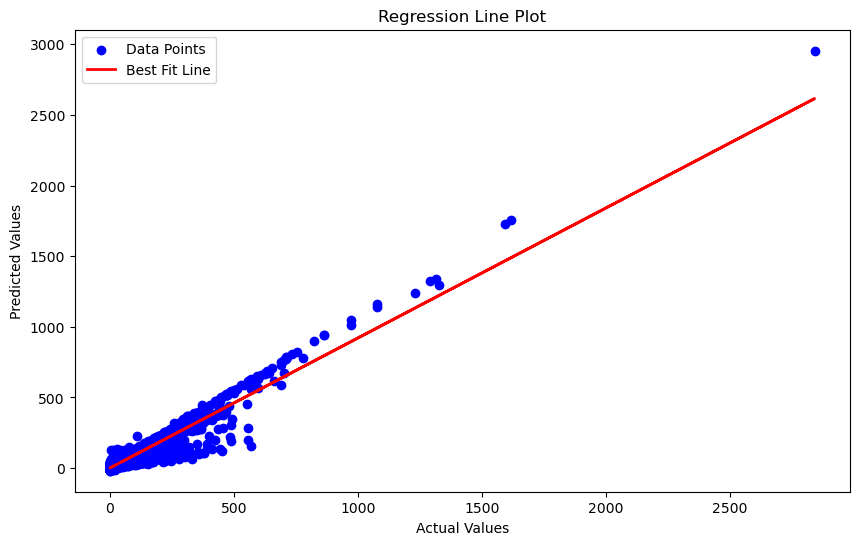

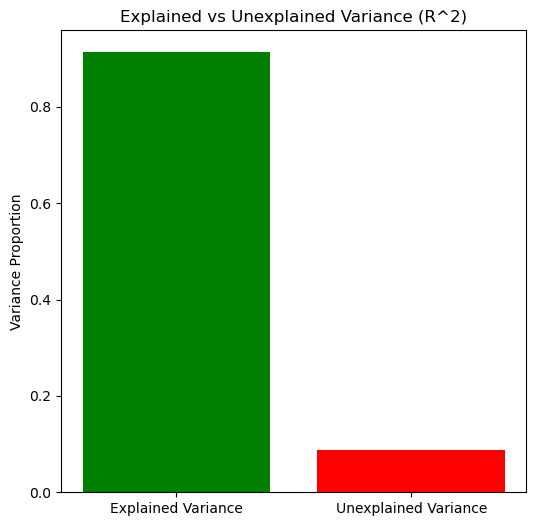

In [23]:
#Running LinearRegression
basic = lr_model(X,y)



Coefficients:
[[-0.66829692 -3.79343403 -0.80203357 -4.76903695  8.00952788  2.02327363
  -2.5234652   7.76636201  4.68480723 34.3638411 ]]

Intercept:
[14.89100444]


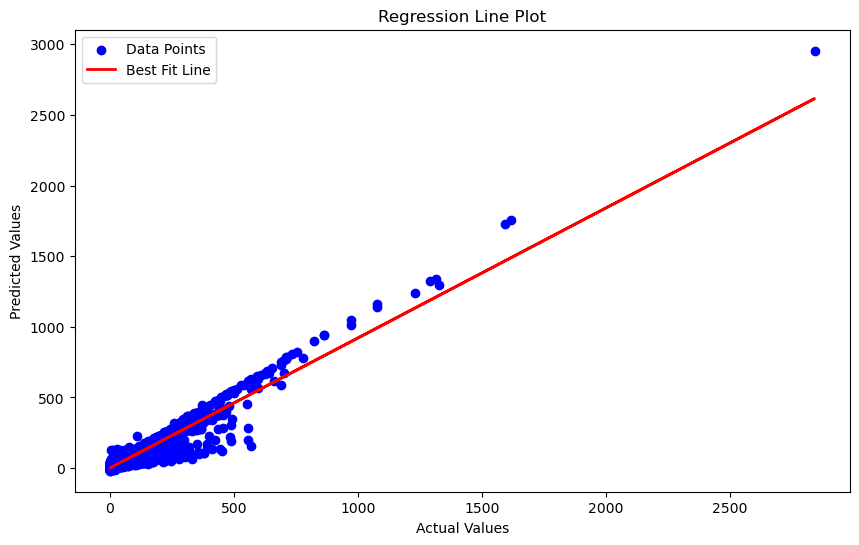

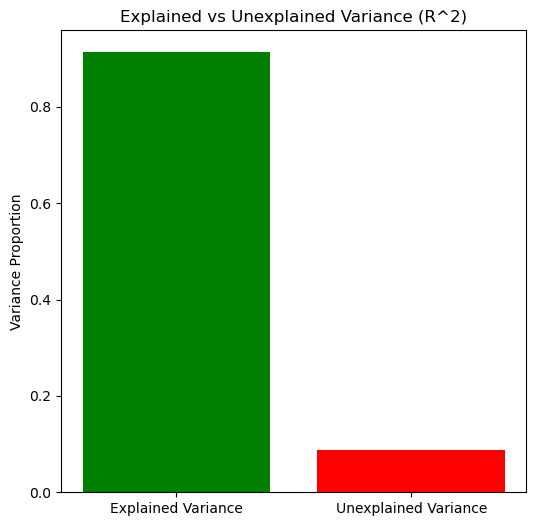

In [27]:
#Add regularisation
reg_l2 = lr_model(X,y,model_name='l2')


Coefficients:
[-0.         -0.63797473  0.         -3.52477836  8.06336584  2.03505765
 -2.32210421  7.62818011  3.75646625 34.44208628]

Intercept:
[13.90073921]


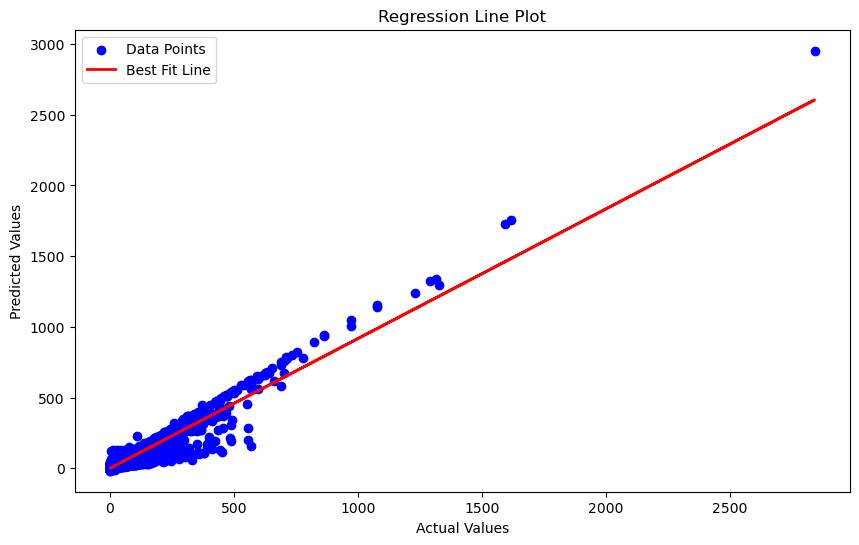

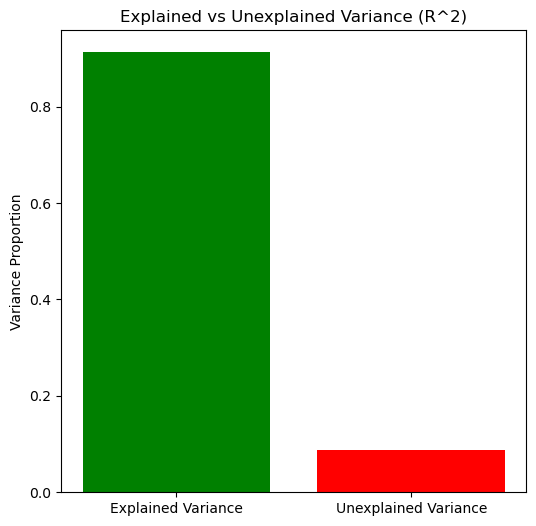

In [24]:
#Add regularisation
reg_l1 = lr_model(X,y,model_name='l1')

the performance of all three models is very similar. Lasso shows a slight improvement in terms of absolute error (MAE), but the differences are minimal, and any of these models could be a reasonable choice depending on the specific use case.

In [70]:
Summary = pd.DataFrame([basic,reg_l1,reg_l2],index=['LR','Lasso','Ridge'])

In [61]:
#Use cross validation on -MAE
cv_basic = lr_model(X,y,scoring='neg_mean_absolute_error',cross_val=True)
cv_l1 = lr_model(X,y,model_name='l1',scoring='neg_mean_absolute_error',alpha=0.2,cross_val=True)
cv_l2 = lr_model(X,y,model_name='l2',scoring='neg_mean_absolute_error',alpha=0.2,cross_val=True)
Summary_cv = pd.DataFrame([cv_basic['neg_mean_absolute_error'],cv_l1['neg_mean_absolute_error'],cv_l2['neg_mean_absolute_error']],index=['LR','Lasso','Ridge'])
Summary_cv['Average'] = Summary_cv.mean(axis=1)
Summary_cv

,0,1,2,3,4,Average
LR,-5.558084,-5.666548,-5.576234,-5.545908,-5.738530,-5.617061
Lasso,-5.429901,-5.531180,-5.431218,-5.416342,-5.600445,-5.481817
Ridge,-5.562883,-5.666353,-5.577220,-5.546192,-5.738479,-5.618225


#### 2.4.2 CrossValidation

In [81]:
#Use cross validation on R^2
cv_basic = lr_model(X,y,cross_val=True)
cv_l1 = lr_model(X,y,model_name='l1',alpha=0.2,cross_val=True)
cv_l2 = lr_model(X,y,model_name='l2',alpha=0.2,cross_val=True)
Summary_cv = pd.DataFrame([cv_basic['r2'],cv_l1['r2'],cv_l2['r2']],index=['LR','Lasso','Ridge'])
Summary_cv['Average'] = Summary_cv.mean(axis=1)
Summary_cv

,0,1,2,3,4,Average
LR,0.899107,0.878152,0.915584,0.903480,0.890141,0.897293
Lasso,0.898291,0.877285,0.914934,0.902528,0.889123,0.896432
Ridge,0.899111,0.878152,0.915583,0.903480,0.890140,0.897293


### 2.5 RandomForest

In [65]:
# Initialize and fit
rf = lr_model(X,y,model_name='rf')

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [67]:
Summary_rf = pd.DataFrame([{'MAE': rf['MAE'], 'MSE': rf['MSE'], 'R^2': rf['R^2'] }],index=['RandomForest'])
Summary_rf

,MAE,MSE,R^2
RandomForest,0.555249,22.169875,0.987093


#### 2.5.2 CrossValidation

In [68]:
rf_cv = lr_model(X,y,model_name='rf',cross_val=True)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

In [76]:
rf_summary_cv = pd.DataFrame([rf_cv['r2']],index=['RandomForest'])
rf_summary_cv['Average'] = rf_summary_cv.mean(axis=1)


### 2.6 Modelling Summary

In [71]:
pd.concat([Summary,Summary_rf])

,MAE,MSE,R^2
LR,5.530700,149.342664,0.913056
Lasso,5.446101,149.563762,0.912927
Ridge,5.530887,149.342480,0.913056
RandomForest,0.555249,22.169875,0.987093


In [82]:
pd.concat([Summary_cv,rf_summary_cv])

,0,1,2,3,4,Average
LR,0.899107,0.878152,0.915584,0.903480,0.890141,0.897293
Lasso,0.898291,0.877285,0.914934,0.902528,0.889123,0.896432
Ridge,0.899111,0.878152,0.915583,0.903480,0.890140,0.897293
RandomForest,0.983243,0.958435,0.995137,0.990241,0.983048,0.982021
